# Libaries

In [1]:
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import seaborn            as sns
import time
import os
from mpl_toolkits.mplot3d import Axes3D

# Dataset

In [3]:
results_path = '../../LargeFilesResults/Model/'
posteriors   = pd.read_csv(os.path.join(results_path, 'betas_rm_sharedprior.csv'))

In [6]:
fit_summary  = '../../LargeFilesResults/Model/fit_summary_rm_sharedprior.csv'
masses       = np.loadtxt(fit_summary, delimiter=',', usecols=[-1], skiprows=1, dtype=float)
redshifts    = np.loadtxt(fit_summary, delimiter=',', usecols=[-2], skiprows=1, dtype=float)
param_header = np.loadtxt(fit_summary, delimiter=',', dtype=str)[0,-2:]
fit_header   = pd.read_csv(os.path.join(results_path, 'entirefit_rm_sharedpriors.csv'), nrows=1).columns

In [7]:
grid       = np.column_stack([redshifts, masses])
grid_split = np.array_split(grid, 5)
grid_split[0].shape

(400, 2)

# Output paths

In [8]:
figs_path = '../../Figs/FigsSharedPrior/'

In [9]:
dimensions = posteriors.columns.values.reshape(5,5)
rows       = dimensions[:,0].size
columns    = dimensions[0,:].size

In [10]:
whan_classes = ['Not classified', 'Retired/Passive', 'wAGN', 'sAGN', 'SF']
palette      = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8','#984ea3']
figsize      = (20, 20)
alpha        = 0.4

/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


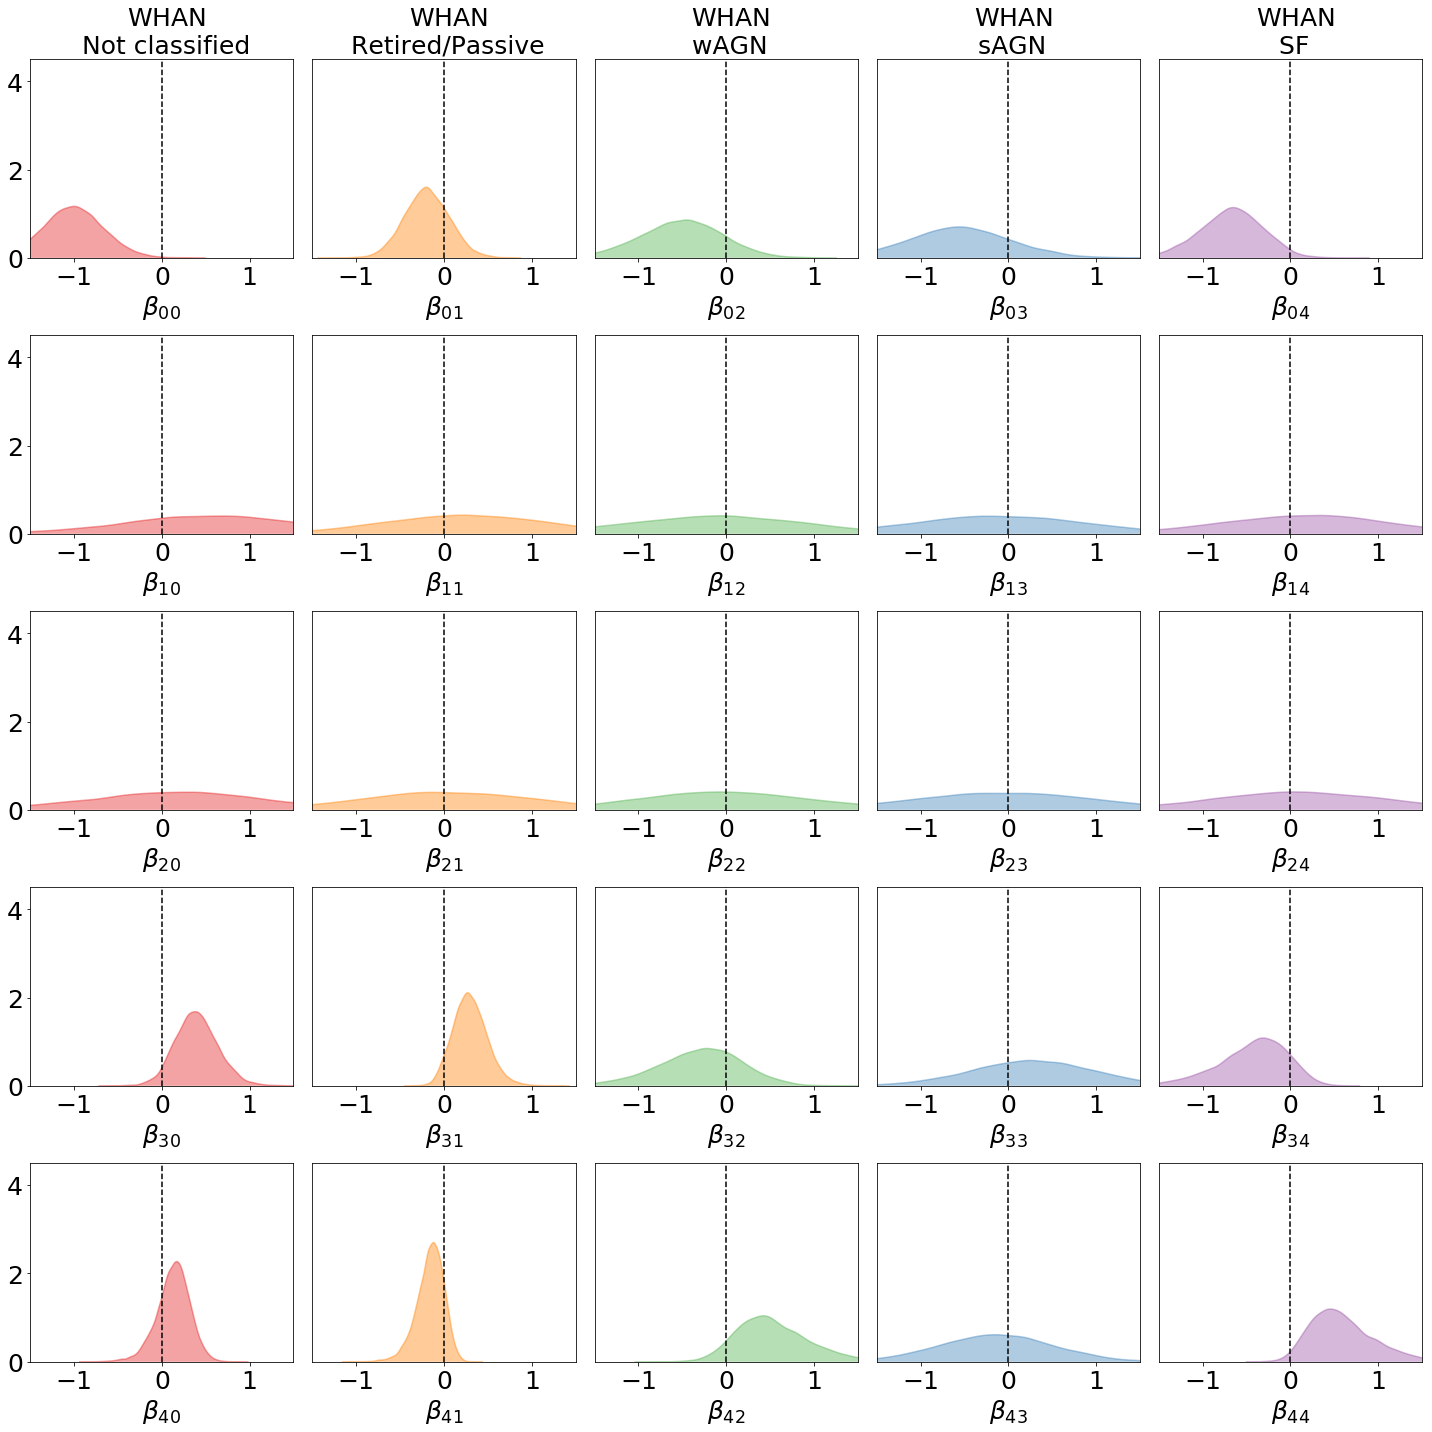

In [11]:
plt.subplots(figsize=figsize)
position = 0
for i in range(rows):
    for j in range(columns):
        position+=1
        plot = plt.subplot(rows, columns, position)
        posterior_temp = posteriors.columns.values.reshape(rows, columns)[i,j]
        sns.kdeplot(posteriors["%s" % posterior_temp].values, shade=True, alpha=alpha, color=palette[j])
        plt.axvline(x=0, linestyle="--", color='black')
        plt.tick_params('both', labelsize='25')
        plt.xlabel(r"$\beta_{%d%d}$" % (i,j), fontsize=25)
        plt.xlim([-1.5,1.5])
        plt.ylim([0,4.5])
        if (i==0):
            plt.title("$\,$ WHAN \n %s" % whan_classes[j], fontsize=25)
            if (j!=0): 
                plot.yaxis.set_visible(False)
            else: 
                plot.yaxis.set_visible(True)
        elif(i>=0)*(j==0): 
            plot.yaxis.set_visible(True)
        else: 
            plot.yaxis.set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, "25betas_rmshared.png"))
plt.savefig(os.path.join(figs_path, "25betas_rmshared.pdf"))
plt.show()

## Separating data by probability (hence, by WHAN class)

In [12]:
for i in range(len(whan_classes)):
    start = time.clock()
    j=i+1
    # reading each probability file and transposing it ---------------------------------------------------------------
    prob_temp    = pd.read_csv(os.path.join(results_path, 'rm_sharedprior_prob0%d.csv' % (j)))
    prob_temp_tr = prob_temp.transpose()
    prob_temp_tr = prob_temp_tr[1:]
    lines_size   = prob_temp_tr.values[:,0].size
    cols_size    = prob_temp_tr.values[0,:].size
    
    # creating the first column --------------------------------------------------------------------------------------
    first_col = []
    for k in range(lines_size):
        first_col.append('prob0%d[%d]' % (j, k))
    first_col = pd.DataFrame(first_col)
    first_col.columns = ['probs']
       
    # setting the header ---------------------------------------------------------------------------------------------
    prob_header = []
    for l in range(cols_size):
        prob_header.append('iter0%d' % l)
    prob_temp_tr.columns = prob_header
    
    # adding the redshift and mass columns at the end of the data frame ----------------------------------------------
    prob_temp_tr.insert(loc=0, value=first_col.values, column='probs')
    prob_temp_tr.insert(loc=(len(prob_header)+1), value=grid_split[i][:,0], column='Z')
    prob_temp_tr.insert(loc=(len(prob_header)+2), value=grid_split[i][:,1], column='LOG_STELLAR_MASS')
    
    # creating a new data frame with the median, percentiles, etc. ---------------------------------------------------
    new_stats_header = ['probs', 'median', 'mean', 'std', '2.5%', '25%', '50%', '75%', '97.5%', 'Z', 
                        'LOG_STELLAR_MASS']
    new_stats = np.zeros_like(np.array(new_stats_header[:-2]))
    for each_prob in range(lines_size):
        all_iterations = prob_temp_tr.values[each_prob, :len(prob_header)] # I'm getting 15000 iter for each prob
        median         = np.median(all_iterations[1:])
        mean           = np.mean(all_iterations[1:])
        std            = np.std(all_iterations[1:])
        percentiles    = np.percentile(a=all_iterations[1:], q=[2.5, 25, 50, 75, 97.5], interpolation='nearest')
        new_line       = np.squeeze(np.column_stack((each_prob, median, mean, std, percentiles.reshape(1,5))))
        new_stats      = np.row_stack((new_stats, new_line.reshape(1, new_line.size)))       
    new_bulk = pd.DataFrame(np.column_stack((new_stats[1:,:], grid_split[i][:, 0], grid_split[i][:, 1])))
    new_bulk.columns = new_stats_header
    new_bulk.to_csv(os.path.join(results_path, 'prob0%d_rmshared_stats.csv' % j), header=True)
    end = time.clock()
    print("This class took %f min to be processed" % ((end-start)/60))

This class took 2.081553 min to be processed
This class took 1.988815 min to be processed
This class took 2.103775 min to be processed
This class took 2.330743 min to be processed
This class took 2.099575 min to be processed


 Analysis to be continued in the next Jupyter Notebook. :-)